In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math
import pickle

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from fix_data_leakage import scale_data_without_leakage, create_sequences


ModuleNotFoundError: No module named 'fix_data_leakage'

In [ ]:
from google.colab import files
files.upload()

In [2]:
!ls

sample_data


In [ ]:
df = pd.read_csv('data2225_clean.csv')
df.head()

,Local Time,index,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed,HolidayName,IsHoliday,Accumulated Hours of Rain
0,2022-01-13 07:00:00,0,353.1,10.0,84.0,98.0,17.08,52.0,100,0.00,1020.0,95.0,15.5,0.6,2.00,Ngày thường,False,0
1,2022-01-13 08:00:00,1,343.5,9.0,87.3,95.7,16.75,48.7,91,0.00,1021.0,94.0,15.4,0.7,2.33,Ngày thường,False,0
2,2022-01-13 09:00:00,2,334.0,8.0,90.7,93.3,16.42,45.3,83,0.50,1022.0,93.0,15.3,1.0,2.66,Ngày thường,False,1
3,2022-01-13 10:00:00,3,324.5,7.0,94.0,91.0,16.09,42.0,75,0.75,1022.0,93.0,15.2,1.5,3.00,Ngày thường,False,2
4,2022-01-13 11:00:00,4,319.6,6.7,95.7,91.3,16.17,39.0,83,0.00,1021.0,87.0,15.6,1.9,3.00,Ngày thường,False,0


In [ ]:
df.drop(columns=['index'], inplace=True)
df['Local Time'] = pd.to_datetime(df['Local Time'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34759 entries, 0 to 34758
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Local Time                 34759 non-null  datetime64[ns]
 1   CO                         34759 non-null  float64       
 2   NO2                        34759 non-null  float64       
 3   O3                         34759 non-null  float64       
 4   PM10                       34759 non-null  float64       
 5   PM25                       34759 non-null  float64       
 6   SO2                        34759 non-null  float64       
 7   Clouds                     34759 non-null  int64         
 8   Precipitation              34759 non-null  float64       
 9   Pressure                   34759 non-null  float64       
 10  Relative Humidity          34759 non-null  float64       
 11  Temperature                34759 non-null  float64       
 12  UV I

In [ ]:

df = df.set_index('Local Time').sort_index()


In [ ]:
df_daily = df.resample('3h').mean(numeric_only=True)
df_daily.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11590 entries, 2022-01-13 06:00:00 to 2025-12-31 21:00:00
Freq: 3h
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CO                         11585 non-null  float64
 1   NO2                        11585 non-null  float64
 2   O3                         11585 non-null  float64
 3   PM10                       11585 non-null  float64
 4   PM25                       11585 non-null  float64
 5   SO2                        11585 non-null  float64
 6   Clouds                     11585 non-null  float64
 7   Precipitation              11585 non-null  float64
 8   Pressure                   11585 non-null  float64
 9   Relative Humidity          11585 non-null  float64
 10  Temperature                11585 non-null  float64
 11  UV Index                   11585 non-null  float64
 12  Wind Speed                 11585 non-null  float64
 13  Is

In [ ]:
idx = df_daily.index
df_daily['day_of_week'] = idx.dayofweek
df_daily['month'] = idx.month
df_daily['hour_sin'] = np.sin(2*np.pi*idx.hour/24)
df_daily['hour_cos'] = np.cos(2*np.pi*idx.hour/24)
df_daily['is_weekend'] = (idx.dayofweek >= 5).astype(int)


In [ ]:
target = 'PM25'
base_features = df_daily.columns.drop(target)

print("n_base_features:", len(base_features))
print(base_features)


n_base_features: 19
Index(['CO', 'NO2', 'O3', 'PM10', 'SO2', 'Clouds', 'Precipitation', 'Pressure',
       'Relative Humidity', 'Temperature', 'UV Index', 'Wind Speed',
       'IsHoliday', 'Accumulated Hours of Rain', 'day_of_week', 'month',
       'hour_sin', 'hour_cos', 'is_weekend'],
      dtype='object')


In [ ]:
lags = [1, 2, 4, 8, 16]   # 3h, 6h, 12h, 1 ngày, 2 ngày (với dữ liệu 3h)


for l in lags:
    df_daily[f"{target}_lag{l}"] = df_daily[target].shift(l)

# drop NaN do shift
df_daily = df_daily.dropna()


In [ ]:
train_end = "2023-12-31"
val_start = "2024-01-01"
val_end = "2024-12-31"
test_start = "2025-01-01"

train_df = df_daily[:train_end]
val_df = df_daily[val_start:val_end]
test_df = df_daily[test_start:]

print(train_df.shape, val_df.shape, test_df.shape)
assert len(train_df) > 0 and len(val_df) > 0 and len(test_df) > 0, "One of train/val/test splits is empty."


(5726, 25) (2927, 25) (2898, 25)


In [ ]:
lag_features = [f"{target}_lag{l}" for l in lags]

features_with_lags = list(dict.fromkeys(base_features.tolist() + lag_features))

print("Features with lags:", features_with_lags)


Features with lags: ['CO', 'NO2', 'O3', 'PM10', 'SO2', 'Clouds', 'Precipitation', 'Pressure', 'Relative Humidity', 'Temperature', 'UV Index', 'Wind Speed', 'IsHoliday', 'Accumulated Hours of Rain', 'day_of_week', 'month', 'hour_sin', 'hour_cos', 'is_weekend', 'PM25_lag1', 'PM25_lag2', 'PM25_lag4', 'PM25_lag8', 'PM25_lag16']


In [ ]:

for split_name, split_df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    numeric_values = split_df.select_dtypes(include=[np.number]).values
    assert np.isfinite(numeric_values).all(), f"{split_name} split contains non-finite numeric values."


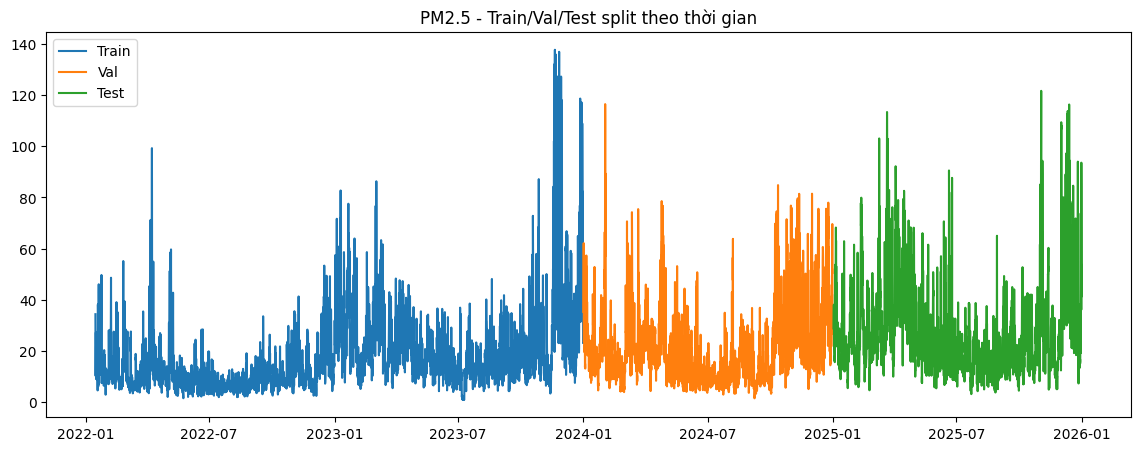

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(train_df.index, train_df[target], label="Train")
plt.plot(val_df.index, val_df[target], label="Val")
plt.plot(test_df.index, test_df[target], label="Test")
plt.title("PM2.5 - Train/Val/Test split theo thời gian")
plt.legend()


In [ ]:
min_corr = 0.02
exclude_high_corr = None

corr = train_df[features_with_lags].corrwith(train_df[target]).abs()
selected_corr = corr[corr >= min_corr].index.tolist()

if exclude_high_corr is not None:
    too_similar = corr[corr > exclude_high_corr].index.tolist()
    selected_corr = [f for f in selected_corr if f not in too_similar]

print(f"Correlation filter: {len(selected_corr)}/{len(features_with_lags)} selected")
print(selected_corr)


Correlation filter: 22/24 selected
['CO', 'NO2', 'O3', 'PM10', 'SO2', 'Clouds', 'Precipitation', 'Pressure', 'Temperature', 'UV Index', 'Wind Speed', 'IsHoliday', 'Accumulated Hours of Rain', 'month', 'hour_sin', 'hour_cos', 'is_weekend', 'PM25_lag1', 'PM25_lag2', 'PM25_lag4', 'PM25_lag8', 'PM25_lag16']


In [ ]:
tree_top_k = 12
random_state = 42
n_estimators = 200

rf = RandomForestRegressor(
    n_estimators=n_estimators,
    random_state=random_state,
    n_jobs=1
)

rf.fit(train_df[features_with_lags], train_df[target])

importances = pd.Series(rf.feature_importances_, index=features_with_lags).sort_values(ascending=False)
selected_tree = importances.head(tree_top_k).index.tolist()

print(selected_tree)
print("\nCác đặc trưng có độ quan trọng cao nhất:")
print(importances.head(tree_top_k))


['PM25_lag1', 'PM10', 'PM25_lag8', 'PM25_lag4', 'PM25_lag16', 'SO2', 'Wind Speed', 'CO', 'UV Index', 'O3', 'NO2', 'Temperature']

Các đặc trưng có độ quan trọng cao nhất:
PM25_lag1      0.672732
PM10           0.171619
PM25_lag8      0.091598
PM25_lag4      0.012166
PM25_lag16     0.011625
SO2            0.004482
Wind Speed     0.003845
CO             0.003840
UV Index       0.003770
O3             0.003344
NO2            0.002985
Temperature    0.002866
dtype: float64


In [ ]:
LOOKBACK = 24
EPOCHS = 20
BATCH_SIZE = 64

feature_sets = [
    ("all_features", features_with_lags),
    ("corr_features", selected_corr),
    ("tree_top_k", selected_tree),
]

rows = []

for set_name, cols in feature_sets:
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    X_train = train_df[cols].values
    X_val   = val_df[cols].values
    X_test  = test_df[cols].values

    y_train = train_df[target].values.reshape(-1, 1)
    y_val   = val_df[target].values.reshape(-1, 1)
    y_test  = test_df[target].values.reshape(-1, 1)

    X_train_s, X_val_s, X_test_s, scaler_X = scale_data_without_leakage(X_train, X_val, X_test)
    y_train_s, y_val_s, y_test_s, scaler_y = scale_data_without_leakage(y_train, y_val, y_test)

    X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s, time_step=LOOKBACK)
    X_val_seq, y_val_seq     = create_sequences(X_val_s, y_val_s, time_step=LOOKBACK)
    X_test_seq, y_test_seq   = create_sequences(X_test_s, y_test_s, time_step=LOOKBACK)

    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', padding='causal',
               input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        GRU(64, return_sequences=True),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=0
    )

    y_val_pred_s  = model.predict(X_val_seq, verbose=0)
    y_test_pred_s = model.predict(X_test_seq, verbose=0)

    y_val_true  = scaler_y.inverse_transform(y_val_seq)
    y_val_pred  = scaler_y.inverse_transform(y_val_pred_s)
    y_test_true = scaler_y.inverse_transform(y_test_seq)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_s)

    val_rmse  = np.sqrt(mean_squared_error(y_val_true.ravel(), y_val_pred.ravel()))
    val_mae   = mean_absolute_error(y_val_true.ravel(), y_val_pred.ravel())
    test_rmse = np.sqrt(mean_squared_error(y_test_true.ravel(), y_test_pred.ravel()))
    test_mae  = mean_absolute_error(y_test_true.ravel(), y_test_pred.ravel())

    rows.append({
        "feature_set": set_name,
        "n_features": len(cols),
        "val_rmse": val_rmse,
        "val_mae": val_mae,
        "test_rmse": test_rmse,
        "test_mae": test_mae
    })

results = pd.DataFrame(rows).sort_values(["val_rmse", "val_mae"]).reset_index(drop=True)
print(results)



Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage
Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage


c:\Users\hungd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage
Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage


c:\Users\hungd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage
Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage


c:\Users\hungd\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     feature_set  n_features   val_rmse    val_mae  test_rmse   test_mae
0     tree_top_k          12  12.485221   9.190064  13.264003   9.451746
1   all_features          24  12.428740   8.811257  13.516386   9.080447
2  corr_features          22  15.057274  11.277865  14.541843  10.476213


In [ ]:
best_set = results.loc[0, "feature_set"]
feature_map = {
    "all_features": features_with_lags,
    "corr_features": selected_corr,
    "tree_top_k": selected_tree,
}
final_features = feature_map[best_set]
best_row = results.loc[0, ["feature_set", "n_features", "val_rmse", "val_mae", "test_rmse", "test_mae"]]

print("Best feature set:", best_set)
print("Best row:", best_row.to_dict())
print("n_final_features:", len(final_features))
print("final_features:", final_features)


Best feature set: tree_top_k
Best row: {'feature_set': 'tree_top_k', 'n_features': 12, 'val_rmse': 12.485220945460256, 'val_mae': 9.190064430977067, 'test_rmse': 13.264003025259967, 'test_mae': 9.451745990536969}
n_final_features: 12
final_features: ['PM25_lag1', 'PM10', 'PM25_lag8', 'PM25_lag4', 'PM25_lag16', 'SO2', 'Wind Speed', 'CO', 'UV Index', 'O3', 'NO2', 'Temperature']


In [ ]:
assert len(final_features) > 0, f"Khong co dac trung nao cho feature set da chon: {best_set}"

if not any(f.startswith(f"{target}_lag") for f in final_features):
    print("Cảnh báo: Không tìm thấy đặc trưng trễ PM25 trong final_features.")

print("Các đặc trưng cuối cùng dùng để huấn luyện:", final_features)

X_train = train_df[final_features].values
X_val   = val_df[final_features].values
X_test  = test_df[final_features].values

y_train = train_df[target].values.reshape(-1, 1)
y_val   = val_df[target].values.reshape(-1, 1)
y_test  = test_df[target].values.reshape(-1, 1)

for split_name, X_arr, y_arr in [
    ("train", X_train, y_train),
    ("val", X_val, y_val),
    ("test", X_test, y_test)
]:
    assert np.isfinite(X_arr).all(), f"X của tập {split_name} chứa giá trị không hữu hạn."
    assert np.isfinite(y_arr).all(), f"y của tập {split_name} chứa giá trị không hữu hạn."


Các đặc trưng cuối cùng dùng để huấn luyện: ['PM25_lag1', 'PM10', 'PM25_lag8', 'PM25_lag4', 'PM25_lag16', 'SO2', 'Wind Speed', 'CO', 'UV Index', 'O3', 'NO2', 'Temperature']


In [ ]:
X_train_s, X_val_s, X_test_s, scaler_X = scale_data_without_leakage(X_train, X_val, X_test)

scale_target = True
if scale_target:
    y_train_s, y_val_s, y_test_s, scaler_y = scale_data_without_leakage(y_train, y_val, y_test)
else:
    y_train_s, y_val_s, y_test_s = y_train, y_val, y_test
    scaler_y = None

for split_name, X_arr, y_arr in [
    ("train", X_train_s, y_train_s),
    ("val", X_val_s, y_val_s),
    ("test", X_test_s, y_test_s)
]:
    assert np.isfinite(X_arr).all(), f"X đã chuẩn hóa của tập {split_name} chứa giá trị không hữu hạn."
    assert np.isfinite(y_arr).all(), f"y đã chuẩn hóa của tập {split_name} chứa giá trị không hữu hạn."

Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage
Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage


In [ ]:
LOOKBACK = 24

X_train_seq, y_train_seq = create_sequences(X_train_s, y_train_s, time_step=LOOKBACK)
X_val_seq, y_val_seq = create_sequences(X_val_s, y_val_s, time_step=LOOKBACK)
X_test_seq, y_test_seq = create_sequences(X_test_s, y_test_s, time_step=LOOKBACK)

print("Sequence shapes:")
print("Train:", X_train_seq.shape, y_train_seq.shape)
print("Val:", X_val_seq.shape, y_val_seq.shape)
print("Test:", X_test_seq.shape, y_test_seq.shape)

for split_name, X_arr, y_arr in [
    ("train", X_train_seq, y_train_seq),
    ("val", X_val_seq, y_val_seq),
    ("test", X_test_seq, y_test_seq)
]:
    assert X_arr.shape[0] > 0 and y_arr.shape[0] > 0, f"{split_name} sequence is empty."
    assert np.isfinite(X_arr).all(), f"{split_name} X_seq contains non-finite values."
    assert np.isfinite(y_arr).all(), f"{split_name} y_seq contains non-finite values."


Sequence shapes:
Train: (5702, 24, 12) (5702, 1)
Val: (2903, 24, 12) (2903, 1)
Test: (2874, 24, 12) (2874, 1)


In [ ]:
from itertools import product
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

search_space = {
    "lookback": [12, 24, 36, 48],
    "conv_filters": [16, 32, 64],
    "gru_units": [(64, 32), (96, 48), (128, 64)],
    "dropout": [0.1, 0.2, 0.3],
    "dense_units": [16, 32],
    "batch_size": [32, 64, 128],
    "learning_rate": [1e-3, 5e-4, 1e-4],
}

all_configs = [
    {
        "lookback": lb,
        "conv_filters": cf,
        "gru_1": gu[0],
        "gru_2": gu[1],
        "dropout": dr,
        "dense_units": du,
        "batch_size": bs,
        "learning_rate": lr,
    }
    for lb, cf, gu, dr, du, bs, lr in product(
        search_space["lookback"],
        search_space["conv_filters"],
        search_space["gru_units"],
        search_space["dropout"],
        search_space["dense_units"],
        search_space["batch_size"],
        search_space["learning_rate"],
    )
]

N_TRIALS = 16
MAX_EPOCHS = 120

rng = np.random.default_rng(42)
trial_indices = rng.choice(len(all_configs), size=min(N_TRIALS, len(all_configs)), replace=False)
trial_configs = [all_configs[i] for i in trial_indices]

search_rows = []
best_obj = None

def build_cnn_gru_from_cfg(cfg, input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Conv1D(filters=cfg["conv_filters"], kernel_size=3, activation='relu', padding='causal'),
        MaxPooling1D(pool_size=2),
        GRU(cfg["gru_1"], return_sequences=True),
        Dropout(cfg["dropout"]),
        GRU(cfg["gru_2"]),
        Dropout(cfg["dropout"]),
        Dense(cfg["dense_units"], activation='relu'),
        Dense(1),
    ])
    model.compile(optimizer=Adam(learning_rate=cfg["learning_rate"]), loss='mse', metrics=['mae'])
    return model

for i, cfg in enumerate(trial_configs, start=1):
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    X_train_seq_t, y_train_seq_t = create_sequences(X_train_s, y_train_s, time_step=cfg["lookback"])
    X_val_seq_t, y_val_seq_t = create_sequences(X_val_s, y_val_s, time_step=cfg["lookback"])
    X_test_seq_t, y_test_seq_t = create_sequences(X_test_s, y_test_s, time_step=cfg["lookback"])

    model = build_cnn_gru_from_cfg(cfg, (X_train_seq_t.shape[1], X_train_seq_t.shape[2]))

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ]

    hist = model.fit(
        X_train_seq_t,
        y_train_seq_t,
        validation_data=(X_val_seq_t, y_val_seq_t),
        epochs=MAX_EPOCHS,
        batch_size=cfg["batch_size"],
        callbacks=callbacks,
        verbose=0,
    )

    y_val_pred_s = model.predict(X_val_seq_t, verbose=0)
    if scaler_y is not None:
        y_val_true = scaler_y.inverse_transform(y_val_seq_t)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_s)
    else:
        y_val_true = y_val_seq_t
        y_val_pred = y_val_pred_s
    val_rmse = np.sqrt(mean_squared_error(y_val_true.ravel(), y_val_pred.ravel()))
    val_mae = mean_absolute_error(y_val_true.ravel(), y_val_pred.ravel())

    row = {
        "trial": i,
        **cfg,
        "val_rmse": val_rmse,
        "val_mae": val_mae,
        "epochs_ran": len(hist.history['loss']),
        "best_val_loss": float(np.min(hist.history['val_loss'])),
    }
    search_rows.append(row)
    print(f"Trial {i:02d}/{len(trial_configs)} | val_rmse={val_rmse:.4f} | val_mae={val_mae:.4f} | cfg={cfg}")

    if (
        best_obj is None
        or val_rmse < best_obj["val_rmse"]
        or (np.isclose(val_rmse, best_obj["val_rmse"]) and val_mae < best_obj["val_mae"])
    ):
        best_obj = {
            "weights": model.get_weights(),
            "history": hist,
            "cfg": cfg,
            "val_rmse": val_rmse,
            "val_mae": val_mae,
            "X_train_seq": X_train_seq_t,
            "y_train_seq": y_train_seq_t,
            "X_val_seq": X_val_seq_t,
            "y_val_seq": y_val_seq_t,
            "X_test_seq": X_test_seq_t,
            "y_test_seq": y_test_seq_t,
        }

search_results = pd.DataFrame(search_rows).sort_values(["val_rmse", "val_mae"]).reset_index(drop=True)
display(search_results.head(10))

best_config = best_obj["cfg"]
tf.keras.backend.clear_session()
cnn_gru_model = build_cnn_gru_from_cfg(best_config, (best_obj["X_train_seq"].shape[1], best_obj["X_train_seq"].shape[2]))
cnn_gru_model.set_weights(best_obj["weights"])
history = best_obj["history"]

X_train_seq = best_obj["X_train_seq"]
y_train_seq = best_obj["y_train_seq"]
X_val_seq = best_obj["X_val_seq"]
y_val_seq = best_obj["y_val_seq"]
X_test_seq = best_obj["X_test_seq"]
y_test_seq = best_obj["y_test_seq"]

print("\nBest config (validation-first):", best_config)
print(f"Best val_rmse: {best_obj['val_rmse']:.4f}")
print(f"Best val_mae: {best_obj['val_mae']:.4f}")
print("Random search completed.")


Trial 01/16 | val_rmse=11.5367 | val_mae=8.6010 | cfg={'lookback': 24, 'conv_filters': 64, 'gru_1': 64, 'gru_2': 32, 'dropout': 0.3, 'dense_units': 16, 'batch_size': 32, 'learning_rate': 0.0005}
Trial 02/16 | val_rmse=10.8068 | val_mae=7.5505 | cfg={'lookback': 12, 'conv_filters': 32, 'gru_1': 64, 'gru_2': 32, 'dropout': 0.1, 'dense_units': 32, 'batch_size': 32, 'learning_rate': 0.0005}
Trial 03/16 | val_rmse=13.9755 | val_mae=11.4013 | cfg={'lookback': 12, 'conv_filters': 32, 'gru_1': 64, 'gru_2': 32, 'dropout': 0.2, 'dense_units': 16, 'batch_size': 32, 'learning_rate': 0.0001}
Trial 04/16 | val_rmse=10.7204 | val_mae=7.7164 | cfg={'lookback': 36, 'conv_filters': 64, 'gru_1': 128, 'gru_2': 64, 'dropout': 0.2, 'dense_units': 16, 'batch_size': 128, 'learning_rate': 0.001}
Trial 05/16 | val_rmse=11.6099 | val_mae=8.5389 | cfg={'lookback': 36, 'conv_filters': 64, 'gru_1': 96, 'gru_2': 48, 'dropout': 0.1, 'dense_units': 16, 'batch_size': 32, 'learning_rate': 0.001}
Trial 06/16 | val_rmse=1

,trial,lookback,conv_filters,gru_1,gru_2,dropout,dense_units,batch_size,learning_rate,val_rmse,val_mae,epochs_ran,best_val_loss
0,16,12,64,96,48,0.1,32,64,0.0010,10.023346,6.825915,18,0.400937
1,11,24,64,64,32,0.2,32,32,0.0010,10.194620,7.428205,16,0.414756
2,4,36,64,128,64,0.2,16,128,0.0010,10.720383,7.716403,27,0.458639
3,2,12,32,64,32,0.1,32,32,0.0005,10.806778,7.550496,19,0.466062
4,12,12,32,64,32,0.1,16,64,0.0005,10.831822,7.577110,19,0.468224
5,13,48,32,64,32,0.3,16,64,0.0005,10.846129,7.686729,31,0.469462
6,1,24,64,64,32,0.3,16,32,0.0005,11.536697,8.601026,21,0.531146
7,6,36,32,128,64,0.2,16,64,0.0010,11.588014,8.245721,32,0.535882
8,5,36,64,96,48,0.1,16,32,0.0010,11.609946,8.538934,21,0.537912
9,9,48,16,96,48,0.1,32,128,0.0005,11.781331,8.144172,11,0.553910



Best config (validation-first): {'lookback': 12, 'conv_filters': 64, 'gru_1': 96, 'gru_2': 48, 'dropout': 0.1, 'dense_units': 32, 'batch_size': 64, 'learning_rate': 0.001}
Best val_rmse: 10.0233
Best val_mae: 6.8259
Random search completed.


In [ ]:
assert len(search_results) > 0, "search_results is empty. Run random search first."
assert "epochs_ran" in search_results.columns, "Missing epochs_ran in search_results."
best_epochs = int(search_results.loc[0, "epochs_ran"])

X_train_val = np.vstack([X_train, X_val])
y_train_val = np.vstack([y_train, y_val])

X_train_val_s, _, X_test_final_s, scaler_X_final = scale_data_without_leakage(
    X_train_val, X_train_val, X_test
)

if scaler_y is not None:
    y_train_val_s, _, y_test_final_s, scaler_y_final = scale_data_without_leakage(
        y_train_val, y_train_val, y_test
    )
else:
    y_train_val_s = y_train_val
    y_test_final_s = y_test
    scaler_y_final = None

lb = best_config["lookback"]
X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_s, y_train_val_s, time_step=lb)
X_test_final_seq, y_test_final_seq = create_sequences(X_test_final_s, y_test_final_s, time_step=lb)

assert X_train_val_seq.shape[0] > 0, "Empty train+val sequences."
assert X_test_final_seq.shape[0] > 0, "Empty test sequences."

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

cnn_gru_model_final = build_cnn_gru_from_cfg(
    best_config,
    (X_train_val_seq.shape[1], X_train_val_seq.shape[2])
)

history_final = cnn_gru_model_final.fit(
    X_train_val_seq,
    y_train_val_seq,
    epochs=best_epochs,
    batch_size=best_config["batch_size"],
    shuffle=False,
    verbose=1
)

cnn_gru_model = cnn_gru_model_final
X_test_seq = X_test_final_seq
y_test_seq = y_test_final_seq
scaler_y = scaler_y_final

print("Final retrain (train+val) completed.")
print("Best config:", best_config)
print("best_epochs:", best_epochs)
print("train+val sequence shape:", X_train_val_seq.shape, y_train_val_seq.shape)
print("test sequence shape:", X_test_final_seq.shape, y_test_final_seq.shape)


Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage
Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage
Epoch 1/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.6249 - mae: 0.5164
Epoch 2/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5347 - mae: 0.4670
Epoch 3/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4313 - mae: 0.4248
Epoch 4/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3809 - mae: 0.3986
Epoch 5/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3411 - mae: 0.3806
Epoch 6/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3103 - mae: 0.3608
Epoch 7/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2878 - mae: 0.3512
Epoch 8/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2776 - mae: 0.3443
Epoch 9/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2571 - mae: 0.3332
Epoch 10/18
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2462 - mae: 0.3295
Epoch 1

In [ ]:
y_test_pred_s = cnn_gru_model.predict(X_test_seq, verbose=0)
assert y_test_pred_s.shape == y_test_seq.shape, "Prediction shape does not match y_test_seq."

if scaler_y is not None:
    y_test_true_actual = scaler_y.inverse_transform(y_test_seq)
    y_test_pred_actual = scaler_y.inverse_transform(y_test_pred_s)
else:
    y_test_true_actual = y_test_seq
    y_test_pred_actual = y_test_pred_s

mae_test = mean_absolute_error(y_test_true_actual.ravel(), y_test_pred_actual.ravel())
rmse_test = np.sqrt(mean_squared_error(y_test_true_actual.ravel(), y_test_pred_actual.ravel()))

print(f"Test MAE: {mae_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

assert np.isfinite(y_test_pred_actual).all(), "Predictions contain non-finite values."


Test MAE: 7.8563
Test RMSE: 11.9713


Using StandardScaler (z-score normalization)
✓ Scaling completed without data leakage


,split,mae,rmse
0,train,4.044706,6.137364
1,val,6.825915,10.023346
2,test,8.092195,12.543110


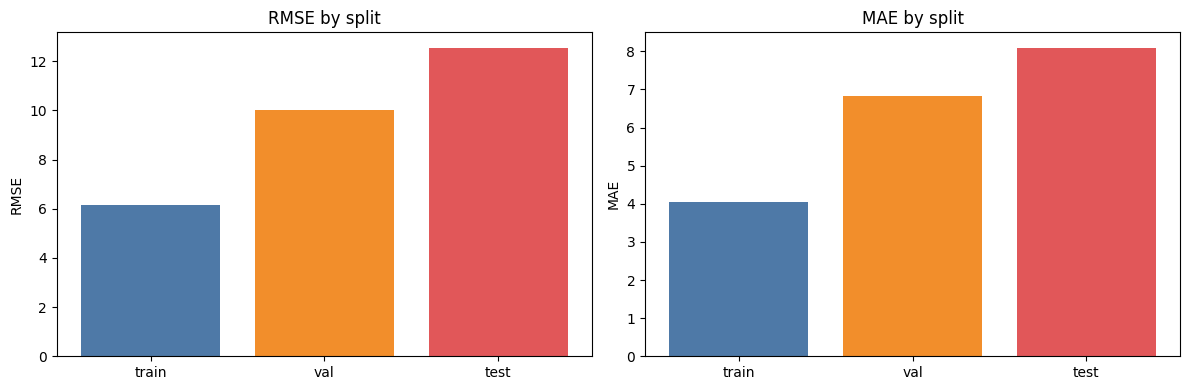

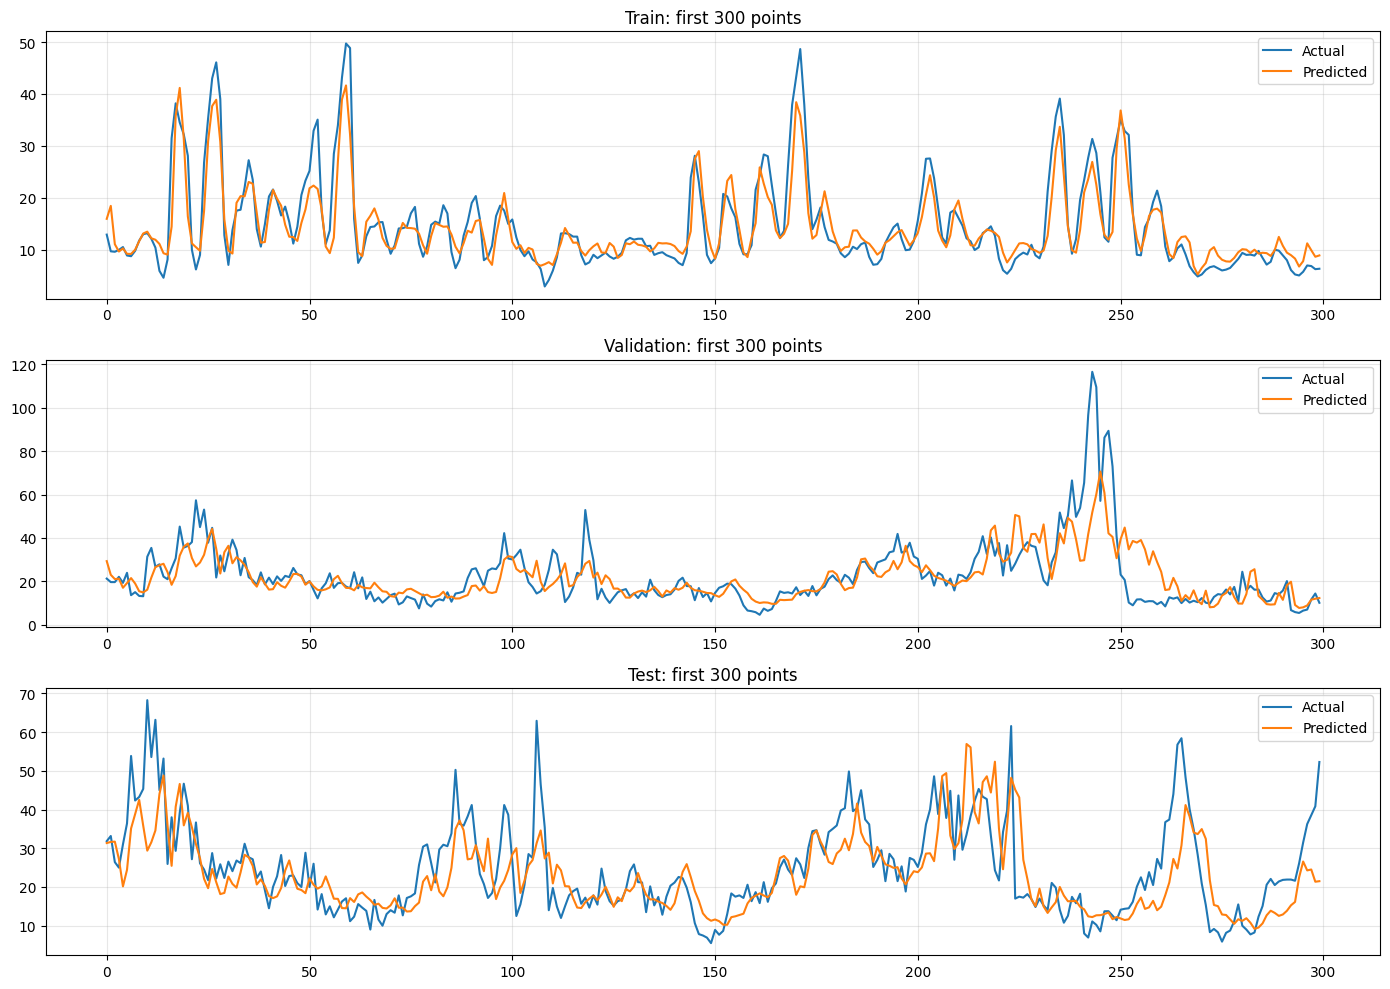

RMSE gap val/train: 63.32%
RMSE gap test/train: 104.37%


In [ ]:
assert "best_obj" in globals(), "best_obj not found. Run random search cell first."
assert "best_config" in globals(), "best_config not found. Run random search cell first."

# Rebuild the best model from validation phase to inspect train/val/test overfitting.
tf.keras.backend.clear_session()
model_overfit_check = build_cnn_gru_from_cfg(
    best_config,
    (best_obj["X_train_seq"].shape[1], best_obj["X_train_seq"].shape[2])
)
model_overfit_check.set_weights(best_obj["weights"])

y_train_pred_s = model_overfit_check.predict(best_obj["X_train_seq"], verbose=0)
y_val_pred_s = model_overfit_check.predict(best_obj["X_val_seq"], verbose=0)
y_test_pred_s = model_overfit_check.predict(best_obj["X_test_seq"], verbose=0)

# Recreate train-only target scaler used in validation phase.
_, _, _, scaler_y_search = scale_data_without_leakage(y_train, y_val, y_test)

y_train_true = scaler_y_search.inverse_transform(best_obj["y_train_seq"])
y_train_pred = scaler_y_search.inverse_transform(y_train_pred_s)
y_val_true = scaler_y_search.inverse_transform(best_obj["y_val_seq"])
y_val_pred = scaler_y_search.inverse_transform(y_val_pred_s)
y_test_true = scaler_y_search.inverse_transform(best_obj["y_test_seq"])
y_test_pred = scaler_y_search.inverse_transform(y_test_pred_s)

metrics_rows = []
for split_name, y_t, y_p in [
    ("train", y_train_true, y_train_pred),
    ("val", y_val_true, y_val_pred),
    ("test", y_test_true, y_test_pred),
]:
    mae = mean_absolute_error(y_t.ravel(), y_p.ravel())
    rmse = np.sqrt(mean_squared_error(y_t.ravel(), y_p.ravel()))
    metrics_rows.append({"split": split_name, "mae": mae, "rmse": rmse})

metrics_df = pd.DataFrame(metrics_rows)
display(metrics_df)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(metrics_df["split"], metrics_df["rmse"], color=["#4e79a7", "#f28e2b", "#e15759"])
axes[0].set_title("RMSE by split")
axes[0].set_ylabel("RMSE")

axes[1].bar(metrics_df["split"], metrics_df["mae"], color=["#4e79a7", "#f28e2b", "#e15759"])
axes[1].set_title("MAE by split")
axes[1].set_ylabel("MAE")
plt.tight_layout()
plt.show()

n_plot = min(300, len(y_test_true))
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
for ax, title, y_t, y_p in [
    (axes[0], "Train", y_train_true, y_train_pred),
    (axes[1], "Validation", y_val_true, y_val_pred),
    (axes[2], "Test", y_test_true, y_test_pred),
]:
    n = min(n_plot, len(y_t))
    ax.plot(y_t[:n], label="Actual", linewidth=1.5)
    ax.plot(y_p[:n], label="Predicted", linewidth=1.5)
    ax.set_title(f"{title}: first {n} points")
    ax.legend(loc="upper right")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

train_rmse = metrics_df.loc[metrics_df["split"] == "train", "rmse"].iloc[0]
val_rmse = metrics_df.loc[metrics_df["split"] == "val", "rmse"].iloc[0]
test_rmse = metrics_df.loc[metrics_df["split"] == "test", "rmse"].iloc[0]
print(f"RMSE gap val/train: {(val_rmse / train_rmse - 1) * 100:.2f}%")
print(f"RMSE gap test/train: {(test_rmse / train_rmse - 1) * 100:.2f}%")


In [ ]:
print("Sample counts (before sequence):")
print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))

print("Sample counts (after sequence):")
print("Train/Val/Test:", len(X_train_seq), len(X_val_seq), len(X_test_seq))

non_finite_total = (
    np.size(X_train_s) - np.isfinite(X_train_s).sum()
    + np.size(X_val_s) - np.isfinite(X_val_s).sum()
    + np.size(X_test_s) - np.isfinite(X_test_s).sum()
    + np.size(y_train_s) - np.isfinite(y_train_s).sum()
    + np.size(y_val_s) - np.isfinite(y_val_s).sum()
    + np.size(y_test_s) - np.isfinite(y_test_s).sum()
)

print("Total non-finite values across scaled arrays:", int(non_finite_total))
assert non_finite_total == 0, "Non-finite values detected after scaling."


Sample counts (before sequence):
Train/Val/Test: 5726 2927 2898
Sample counts (after sequence):
Train/Val/Test: 5714 2915 2886
Total non-finite values across scaled arrays: 0
